In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load in Data Set (Coral 10 colors)

In [ ]:
import pandas as pd

def hex_to_rgb(hex_color):
    """
    Convert a hexadecimal color code to its RGB representation.

    Args:
        hex_color (str): A string representing a hexadecimal color code,
                         e.g., '#ffcc00' or 'ffcc00'.

    Returns:
        list: A list of three integers corresponding to the RGB values,
              e.g., [255, 204, 0] for '#ffcc00'.
    """
    hex_color = hex_color.lstrip('#')  # Remove the '#' if present
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]  # Convert hex pairs to RGB values


def convert_colors_to_rgb(data):
    """
    Convert hex color columns in a DataFrame to separate RGB columns.

    This function assumes the presence of columns named 'color1' to 'color5',
    each containing a hexadecimal color code. It converts each hex color to its
    RGB representation and adds three new columns for each color:
    'color{i}_R', 'color{i}_G', and 'color{i}_B'.

    Args:
        data (pd.DataFrame): A pandas DataFrame with columns named 'color1' through 'color5',
                             each containing a hex color string (e.g., '#ffcc00').

    Returns:
        pd.DataFrame: The original DataFrame augmented with 15 new columns for RGB components.
    """
    for i in range(1, 6):  # Loop through color1 to color5
        color_column = f'color{i}'
        data[[f'color{i}_R', f'color{i}_G', f'color{i}_B']] = data[color_column].apply(
            lambda x: pd.Series(hex_to_rgb(x))
        )
    return data


# `coral_data10` is your loaded DataFrame
coral_data = pd.read_csv('coral_colors10.csv')

# Convert color columns to RGB
coral_data = convert_colors_to_rgb(coral_data)

# Drop the original hex color columns
coral_data = coral_data.drop(columns=[f'color{i}' for i in range(1, 11)])

# Undersample the majority class (CORAL) to match CORAL_BL
coral = coral_data[coral_data['label'] == 'CORAL']
coral_bl = coral_data[coral_data['label'] == 'CORAL_BL']

coral_sampled = coral.sample(n=len(coral_bl), random_state=42)
balanced_data = pd.concat([coral_sampled, coral_bl])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the result
balanced_data.head()



,label,frequency1,frequency2,frequency3,frequency4,frequency5,frequency6,frequency7,frequency8,frequency9,...,color7_B,color8_R,color8_G,color8_B,color9_R,color9_G,color9_B,color10_R,color10_G,color10_B
0,CORAL,0.4008,0.1609,0.1363,0.1005,0.0857,0.0508,0.0267,0.0230,0.0077,...,47,83,74,64,102,94,85,120,119,108
1,CORAL,0.1858,0.1405,0.1102,0.1100,0.1091,0.1047,0.0887,0.0738,0.0571,...,61,105,115,68,117,127,77,130,146,94
2,CORAL,0.1664,0.1387,0.1365,0.1330,0.1225,0.1037,0.0784,0.0654,0.0331,...,98,59,83,51,115,171,112,43,64,42
3,CORAL_BL,0.1971,0.1855,0.1753,0.1267,0.0921,0.0884,0.0807,0.0288,0.0161,...,135,132,115,71,102,85,55,66,55,39
4,CORAL_BL,0.1377,0.1179,0.1157,0.1129,0.1004,0.0989,0.0971,0.0943,0.0873,...,99,151,178,173,86,93,87,72,76,71


In [ ]:
# Ensure balanced dataset
train_X = balanced_data.drop('label', axis=1)
train_y = balanced_data['label']
count = train_y.value_counts()
print(count/len(train_y))


label
CORAL       0.5
CORAL_BL    0.5
Name: count, dtype: float64


In [ ]:
# Train test val split (default 0.25)
from sklearn.model_selection import train_test_split
X_trainVal, X_test, y_trainVal, y_test = train_test_split(train_X, train_y, random_state=42, stratify=train_y)
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, random_state=42, stratify=y_trainVal)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Test following parameter combinations
param_grid = {
    'n_estimators': [25, 50, 75],
    'max_depth': [15],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4, 5]
}

# Build random forest model and search for best parameters
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
validation_score = best_rf_model.score(X_val, y_val)
print(f'Validation Accuracy: {validation_score:.4f}')


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Validation Accuracy: 0.8112


In [ ]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Final evaluation on the test set
test_score = best_rf_model.score(X_test, y_test)
print(f'Test Accuracy: {test_score:.4f}')

Best parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.8070448070448072
Test Accuracy: 0.7972


0.8941346367473895


Text(0, 0.5, 'True Positive Rate')

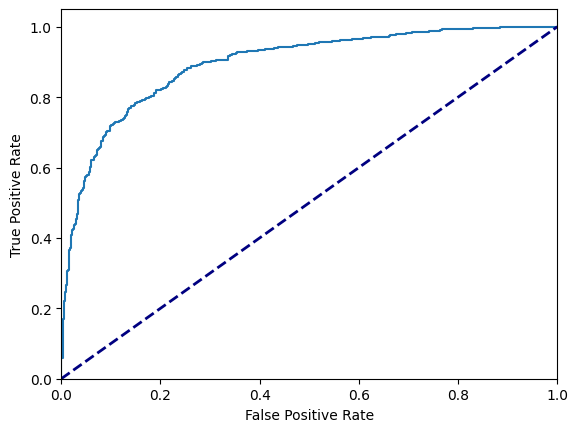

In [ ]:
# Print AUC graph
import numpy as np
from sklearn import metrics

pred = best_rf_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label="CORAL_BL")
print(metrics.auc(fpr, tpr))

import matplotlib.pylab as plt
lw=2
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on the test set
y_pred = best_rf_model.predict(X_test)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification Report (includes precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=best_rf_model.classes_))



Test Accuracy: 0.7972

Classification Report:
              precision    recall  f1-score   support

       CORAL       0.81      0.78      0.79       858
    CORAL_BL       0.79      0.82      0.80       858

    accuracy                           0.80      1716
   macro avg       0.80      0.80      0.80      1716
weighted avg       0.80      0.80      0.80      1716



Text(50.722222222222214, 0.5, 'True')

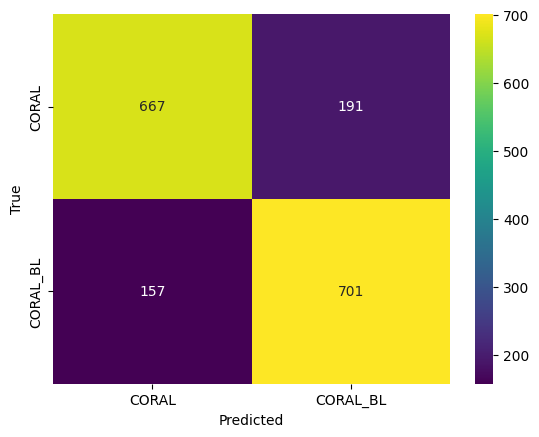

In [ ]:
# Print confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')


# CORAL 5 COLORS

In [1]:
import pandas as pd

def hex_to_rgb(hex_color):
    """
    Convert a hexadecimal color code to its RGB representation.

    Args:
        hex_color (str): A string representing a hexadecimal color code,
                         e.g., '#ffcc00' or 'ffcc00'.

    Returns:
        list: A list of three integers corresponding to the RGB values,
              e.g., [255, 204, 0] for '#ffcc00'.
    """
    hex_color = hex_color.lstrip('#')  # Remove the '#' if present
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]  # Convert hex pairs to RGB values


def convert_colors_to_rgb(data):
    """
    Convert hex color columns in a DataFrame to separate RGB columns.

    This function assumes the presence of columns named 'color1' to 'color5',
    each containing a hexadecimal color code. It converts each hex color to its
    RGB representation and adds three new columns for each color:
    'color{i}_R', 'color{i}_G', and 'color{i}_B'.

    Args:
        data (pd.DataFrame): A pandas DataFrame with columns named 'color1' through 'color5',
                             each containing a hex color string (e.g., '#ffcc00').

    Returns:
        pd.DataFrame: The original DataFrame augmented with 15 new columns for RGB components.
    """
    for i in range(1, 6):  # Loop through color1 to color5
        color_column = f'color{i}'
        data[[f'color{i}_R', f'color{i}_G', f'color{i}_B']] = data[color_column].apply(
            lambda x: pd.Series(hex_to_rgb(x))
        )
    return data


# `coral_data` is your loaded DataFrame
coral_data = pd.read_csv('coral_colors5.csv')

# Convert color columns to RGB
coral_data = convert_colors_to_rgb(coral_data)

# Drop the original hex color columns
coral_data = coral_data.drop(columns=[f'color{i}' for i in range(1, 6)])

# Optional: Save to new data frame
# coral_data.to_csv('coral_colors5_rgb.csv', index=False)

# Undersample the majority class (CORAL) to match CORAL_BL
coral = coral_data[coral_data['label'] == 'CORAL']
coral_bl = coral_data[coral_data['label'] == 'CORAL_BL']

coral_sampled = coral.sample(n=len(coral_bl), random_state=42)
balanced_data = pd.concat([coral_sampled, coral_bl])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the result
balanced_data.head()



,label,frequency1,frequency2,frequency3,frequency4,frequency5,color1_R,color1_G,color1_B,color2_R,...,color2_B,color3_R,color3_G,color3_B,color4_R,color4_G,color4_B,color5_R,color5_G,color5_B
0,CORAL,0.5001,0.3382,0.1050,0.0433,0.0134,13,11,9,35,...,19,51,43,33,78,69,59,113,109,99
1,CORAL,0.3365,0.2448,0.1992,0.1388,0.0807,40,49,29,59,...,42,79,89,53,99,109,64,120,132,81
2,CORAL,0.2898,0.2851,0.2209,0.1056,0.0986,82,119,76,71,...,66,94,141,86,108,161,103,56,80,49
3,CORAL_BL,0.3762,0.2717,0.2196,0.1063,0.0262,182,175,112,194,...,127,169,157,95,147,130,79,90,75,50
4,CORAL_BL,0.2409,0.2397,0.1982,0.1894,0.1318,135,155,147,120,...,127,102,113,105,148,173,167,83,88,83


In [2]:
# Ensure balanced dataset
train_X = balanced_data.drop('label', axis=1)
train_y = balanced_data['label']
count = train_y.value_counts()
print(count/len(train_y))


label
CORAL       0.5
CORAL_BL    0.5
Name: count, dtype: float64


In [3]:
# Train test val split (default 0.25)
from sklearn.model_selection import train_test_split
X_trainVal, X_test, y_trainVal, y_test = train_test_split(train_X, train_y, random_state=42, stratify=train_y)
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, random_state=42, stratify=y_trainVal)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Test the following parameter combinations
param_grid = {
    'n_estimators': range(100, 310, 10),
    'max_depth': range(15, 26, 1),
    'min_samples_split': range(1, 6, 1),
    'min_samples_leaf': [1, 2, 4]
}

# Build a random forest model
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
validation_score = best_rf_model.score(X_val, y_val)
print(f'Validation Accuracy: {validation_score:.4f}')


Fitting 3 folds for each of 3465 candidates, totalling 10395 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
2079 fits failed out of a total of 10395.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2079 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/

Validation Accuracy: 0.8236


In [ ]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Final evaluation on the test set
test_score = best_rf_model.score(X_test, y_test)
print(f'Test Accuracy: {test_score:.4f}')

Best parameters: {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 260}
Best score: 0.8041958041958042
Test Accuracy: 0.8001


0.8954869932285578


Text(0, 0.5, 'True Positive Rate')

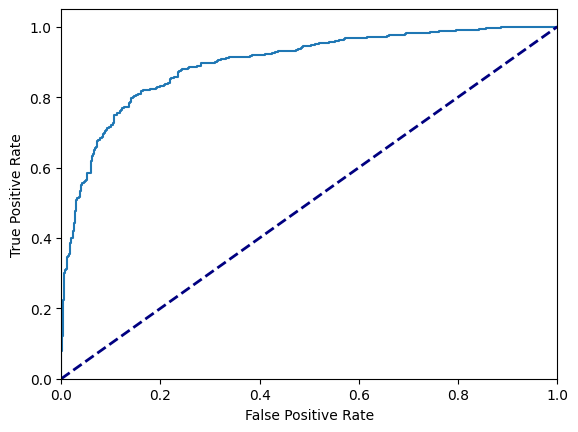

In [ ]:
import numpy as np
from sklearn import metrics
# Print AUC graph
pred = best_rf_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label="CORAL_BL")
print(metrics.auc(fpr, tpr))

import matplotlib.pylab as plt
lw=2
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on the test set
y_pred = best_rf_model.predict(X_test)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification Report (includes precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=best_rf_model.classes_))



Test Accuracy: 0.8001

Classification Report:
              precision    recall  f1-score   support

       CORAL       0.80      0.81      0.80       858
    CORAL_BL       0.80      0.79      0.80       858

    accuracy                           0.80      1716
   macro avg       0.80      0.80      0.80      1716
weighted avg       0.80      0.80      0.80      1716



Text(50.722222222222214, 0.5, 'True')

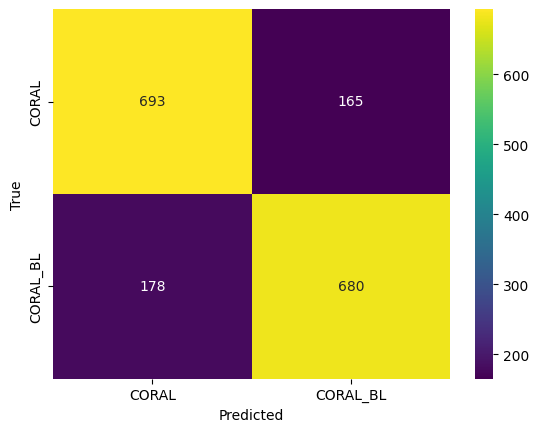

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Print confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')


# SVM CORAL 5 COLORS

In [ ]:
import pandas as pd

def hex_to_rgb(hex_color):
    """
    Convert a hexadecimal color code to its RGB representation.

    Args:
        hex_color (str): A string representing a hexadecimal color code,
                         e.g., '#ffcc00' or 'ffcc00'.

    Returns:
        list: A list of three integers corresponding to the RGB values,
              e.g., [255, 204, 0] for '#ffcc00'.
    """
    hex_color = hex_color.lstrip('#')  # Remove the '#' if present
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]  # Convert hex pairs to RGB values


def convert_colors_to_rgb(data):
    """
    Convert hex color columns in a DataFrame to separate RGB columns.

    This function assumes the presence of columns named 'color1' to 'color5',
    each containing a hexadecimal color code. It converts each hex color to its
    RGB representation and adds three new columns for each color:
    'color{i}_R', 'color{i}_G', and 'color{i}_B'.

    Args:
        data (pd.DataFrame): A pandas DataFrame with columns named 'color1' through 'color5',
                             each containing a hex color string (e.g., '#ffcc00').

    Returns:
        pd.DataFrame: The original DataFrame augmented with 15 new columns for RGB components.
    """
    for i in range(1, 6):  # Loop through color1 to color5
        color_column = f'color{i}'
        data[[f'color{i}_R', f'color{i}_G', f'color{i}_B']] = data[color_column].apply(
            lambda x: pd.Series(hex_to_rgb(x))
        )
    return data


# `coral_data` is your loaded DataFrame
coral_data = pd.read_csv('coral_colors5.csv')

# Convert color columns to RGB
coral_data = convert_colors_to_rgb(coral_data)

# Drop the original hex color columns
coral_data = coral_data.drop(columns=[f'color{i}' for i in range(1, 6)])

# Optional: Save to new data frame
# coral_data.to_csv('coral_colors5_rgb.csv', index=False)

# Undersample the majority class (CORAL) to match CORAL_BL
coral = coral_data[coral_data['label'] == 'CORAL']
coral_bl = coral_data[coral_data['label'] == 'CORAL_BL']

coral_sampled = coral.sample(n=len(coral_bl), random_state=42)
balanced_data = pd.concat([coral_sampled, coral_bl])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the result
balanced_data.head()



,label,frequency1,frequency2,frequency3,frequency4,frequency5,color1_R,color1_G,color1_B,color2_R,...,color2_B,color3_R,color3_G,color3_B,color4_R,color4_G,color4_B,color5_R,color5_G,color5_B
0,CORAL,0.5001,0.3382,0.1050,0.0433,0.0134,13,11,9,35,...,19,51,43,33,78,69,59,113,109,99
1,CORAL,0.3365,0.2448,0.1992,0.1388,0.0807,40,49,29,59,...,42,79,89,53,99,109,64,120,132,81
2,CORAL,0.2898,0.2851,0.2209,0.1056,0.0986,82,119,76,71,...,66,94,141,86,108,161,103,56,80,49
3,CORAL_BL,0.3762,0.2717,0.2196,0.1063,0.0262,182,175,112,194,...,127,169,157,95,147,130,79,90,75,50
4,CORAL_BL,0.2409,0.2397,0.1982,0.1894,0.1318,135,155,147,120,...,127,102,113,105,148,173,167,83,88,83


In [5]:
# Ensure balanced dataset
train_X = balanced_data.drop('label', axis=1)
train_y = balanced_data['label']
count = train_y.value_counts()
print(count/len(train_y))

label
CORAL       0.5
CORAL_BL    0.5
Name: count, dtype: float64


In [6]:
from sklearn.model_selection import train_test_split
# Split into train test val sets (default 0.25)
X_trainVal, X_test, y_trainVal, y_test = train_test_split(train_X, train_y, random_state=42, stratify=train_y)
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, random_state=42, stratify=y_trainVal)

In [7]:
from sklearn.preprocessing import StandardScaler

# Scale only using training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit + transform on train
X_val_scaled = scaler.transform(X_val)          # Transform val with train scale
X_test_scaled = scaler.transform(X_test)        # Transform test with train scale

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the SVM model
svm_model = SVC(probability=True)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'C': [5, 10, 15, 20],               # Regularization parameter
    'kernel': ['rbf', 'poly'],     # Kernel types
    'gamma': ['scale'],      # Kernel coefficient for 'rbf' kernel
    'degree': [1, 2, 3, 4]              # Polynomial degree (if using 'poly' kernel)
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search on training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters from grid search
print(f"Best Parameters: {grid_search.best_params_}")

# Get the best estimator
best_svm = grid_search.best_estimator_



Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'C': 20, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the model on the validation set
y_val_pred = best_svm.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

# Evaluate on the test set
y_test_pred = best_svm.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))




Validation Accuracy: 0.8166
Classification Report for Validation Set:
              precision    recall  f1-score   support

       CORAL       0.79      0.86      0.82       644
    CORAL_BL       0.84      0.78      0.81       643

    accuracy                           0.82      1287
   macro avg       0.82      0.82      0.82      1287
weighted avg       0.82      0.82      0.82      1287


Test Accuracy: 0.7978
Classification Report for Test Set:
              precision    recall  f1-score   support

       CORAL       0.78      0.83      0.80       858
    CORAL_BL       0.82      0.77      0.79       858

    accuracy                           0.80      1716
   macro avg       0.80      0.80      0.80      1716
weighted avg       0.80      0.80      0.80      1716



0.8812123875853677


Text(0, 0.5, 'True Positive Rate')

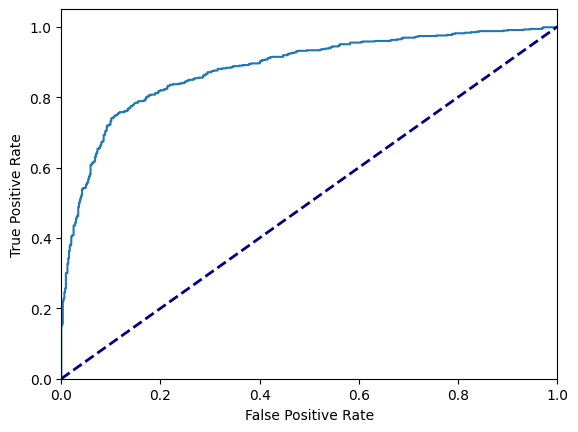

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pylab as plt

# Print AUC graph
pred = best_svm.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label="CORAL_BL")
print(metrics.auc(fpr, tpr))

lw=2
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Text(50.722222222222214, 0.5, 'True')

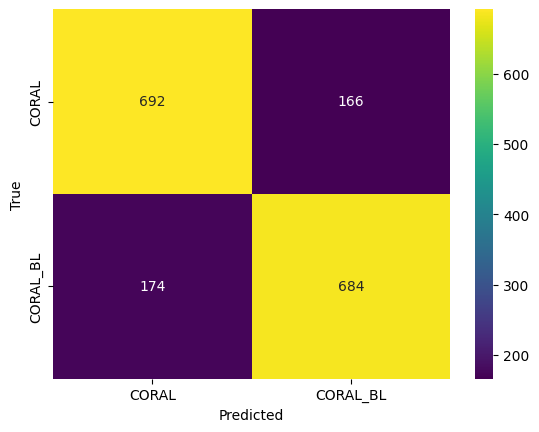

In [ ]:
# --- Classification Report + Confusion Matrix ---
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Print confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=best_svm.classes_, yticklabels=best_svm.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')

# KNN 5 COLORS

In [ ]:
import pandas as pd

def hex_to_rgb(hex_color):
    """
    Convert a hexadecimal color code to its RGB representation.

    Args:
        hex_color (str): A string representing a hexadecimal color code,
                         e.g., '#ffcc00' or 'ffcc00'.

    Returns:
        list: A list of three integers corresponding to the RGB values,
              e.g., [255, 204, 0] for '#ffcc00'.
    """
    hex_color = hex_color.lstrip('#')  # Remove the '#' if present
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]  # Convert hex pairs to RGB values


def convert_colors_to_rgb(data):
    """
    Convert hex color columns in a DataFrame to separate RGB columns.

    This function assumes the presence of columns named 'color1' to 'color5',
    each containing a hexadecimal color code. It converts each hex color to its
    RGB representation and adds three new columns for each color:
    'color{i}_R', 'color{i}_G', and 'color{i}_B'.

    Args:
        data (pd.DataFrame): A pandas DataFrame with columns named 'color1' through 'color5',
                             each containing a hex color string (e.g., '#ffcc00').

    Returns:
        pd.DataFrame: The original DataFrame augmented with 15 new columns for RGB components.
    """
    for i in range(1, 6):  # Loop through color1 to color5
        color_column = f'color{i}'
        data[[f'color{i}_R', f'color{i}_G', f'color{i}_B']] = data[color_column].apply(
            lambda x: pd.Series(hex_to_rgb(x))
        )
    return data


# `coral_data` is your loaded DataFrame
coral_data = pd.read_csv('coral_colors5.csv')

# Convert color columns to RGB
coral_data = convert_colors_to_rgb(coral_data)

# Drop the original hex color columns
coral_data = coral_data.drop(columns=[f'color{i}' for i in range(1, 6)])

# Optional: Save to new data frame
# coral_data.to_csv('coral_colors5_rgb.csv', index=False)

# Undersample the majority class (CORAL) to match CORAL_BL
coral = coral_data[coral_data['label'] == 'CORAL']
coral_bl = coral_data[coral_data['label'] == 'CORAL_BL']

coral_sampled = coral.sample(n=len(coral_bl), random_state=42)
balanced_data = pd.concat([coral_sampled, coral_bl])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the result
balanced_data.head()



label
CORAL       0.5
CORAL_BL    0.5
Name: count, dtype: float64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Grid Search KNN
param_grid = {
    'n_neighbors': [9, 15, 50, 100],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_knn = grid_search.best_estimator_
# Best Hyperparameters
print(f"\nBest KNN Parameters: {grid_search.best_params_}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best KNN Parameters: {'n_neighbors': 50, 'p': 2, 'weights': 'distance'}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.77829578 0.77415177 0.77492877        nan 0.77415177
 0.77337477 0.77389277        nan 0.77803678 0.77674178 0.77855478
        nan 0.76974877 0.76767677 0.77207977]
  warnings.warn(


In [ ]:

# Validation Set Evaluation
val_accuracy = best_knn.score(X_val_scaled, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.7910


AUC: 0.8761


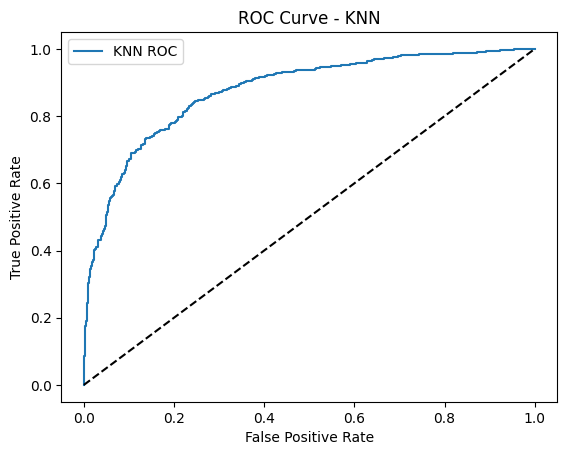

In [ ]:
# ROC Curve
pred_proba = best_knn.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_val, pred_proba, pos_label="CORAL_BL")
print(f"AUC: {metrics.auc(fpr, tpr):.4f}")

plt.figure()
plt.plot(fpr, tpr, label='KNN ROC')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.show()

In [ ]:
# Classification Report on Test
y_test_pred = best_knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=best_knn.classes_))



Test Accuracy: 0.7762

Classification Report:
              precision    recall  f1-score   support

       CORAL       0.77      0.79      0.78       858
    CORAL_BL       0.78      0.76      0.77       858

    accuracy                           0.78      1716
   macro avg       0.78      0.78      0.78      1716
weighted avg       0.78      0.78      0.78      1716



Text(50.722222222222214, 0.5, 'True')

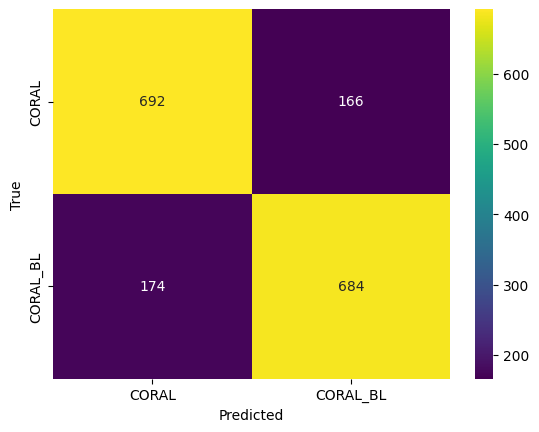

In [ ]:
# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')

# LOG REGRESSION 5 COLORS

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Logistic Regression with Grid Search
param_grid = {
    'C': [0.1],
    'penalty': ['l2'],  # 'l1' can also be used with solver='liblinear'
    'solver': ['liblinear']  # supports both l1 and l2
}

log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_log_reg = grid_search.best_estimator_
print(f"Best Logistic Regression Parameters: {grid_search.best_params_}")





Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
# Validation Accuracy
val_score = best_log_reg.score(X_val_scaled, y_val)
print(f"Validation Accuracy: {val_score:.4f}")



Validation Accuracy: 0.7995


AUC: 0.8708


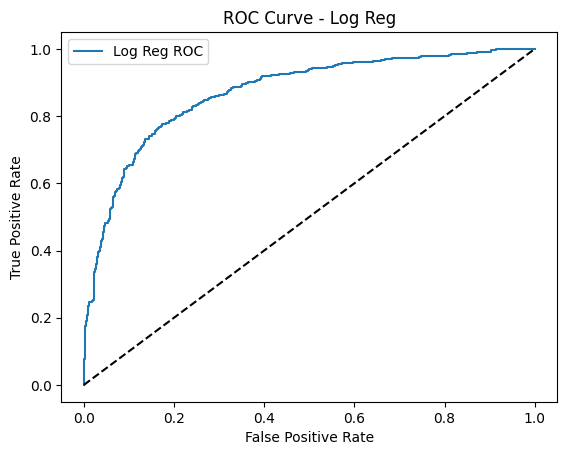

In [ ]:
# Print AUC graph
pred_proba = best_log_reg.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_val, pred_proba, pos_label="CORAL_BL")
print(f"AUC: {metrics.auc(fpr, tpr):.4f}")

plt.figure()
plt.plot(fpr, tpr, label='Log Reg ROC')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Log Reg')
plt.legend()
plt.show()



In [ ]:
# Test Set Evaluation
y_test_pred = best_log_reg.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=best_log_reg.classes_))



Test Accuracy: 0.7885

Classification Report (Test Set):
              precision    recall  f1-score   support

       CORAL       0.78      0.81      0.79       858
    CORAL_BL       0.80      0.76      0.78       858

    accuracy                           0.79      1716
   macro avg       0.79      0.79      0.79      1716
weighted avg       0.79      0.79      0.79      1716



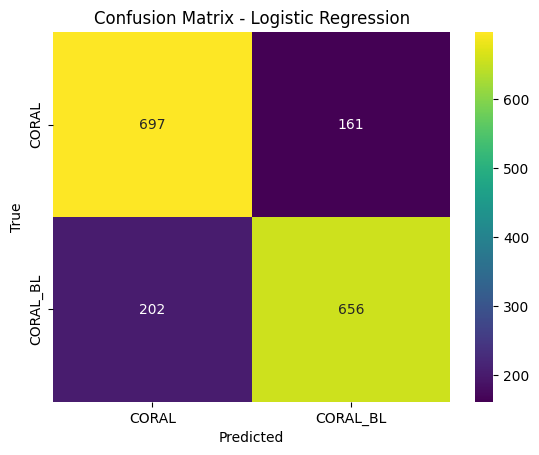

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis',
            xticklabels=best_log_reg.classes_, yticklabels=best_log_reg.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# XGB

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='logloss')

from sklearn.preprocessing import LabelEncoder

# Encode labels to 0/1
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


# Parameters for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Build xgb model
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train_encoded)

# Pick the best model
best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print("Validation Accuracy:", best_xgb.score(X_val_scaled, y_val_encoded))


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Validation Accuracy: 0.8228438228438228


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:46:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC: 0.9000


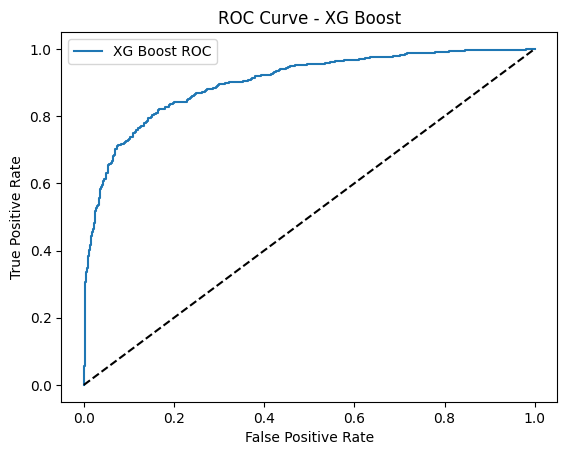

In [25]:
import numpy as np
from sklearn import metrics
import matplotlib.pylab as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Print AUC
pred_proba = best_xgb.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_val, pred_proba, pos_label="CORAL_BL")
print(f"AUC: {metrics.auc(fpr, tpr):.4f}")

plt.figure()
plt.plot(fpr, tpr, label='XG Boost ROC')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XG Boost')
plt.legend()
plt.show()



In [24]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode y_train and y_test with the same LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Predict on the scaled test set
y_test_pred_encoded = best_xgb.predict(X_test_scaled)

# Decode predictions back to original labels
y_test_pred_labels = le.inverse_transform(y_test_pred_encoded)

# Evaluation using string labels
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_labels, target_names=le.classes_))



Test Accuracy: 0.7972

Classification Report (Test Set):
              precision    recall  f1-score   support

       CORAL       0.79      0.81      0.80       858
    CORAL_BL       0.80      0.79      0.80       858

    accuracy                           0.80      1716
   macro avg       0.80      0.80      0.80      1716
weighted avg       0.80      0.80      0.80      1716



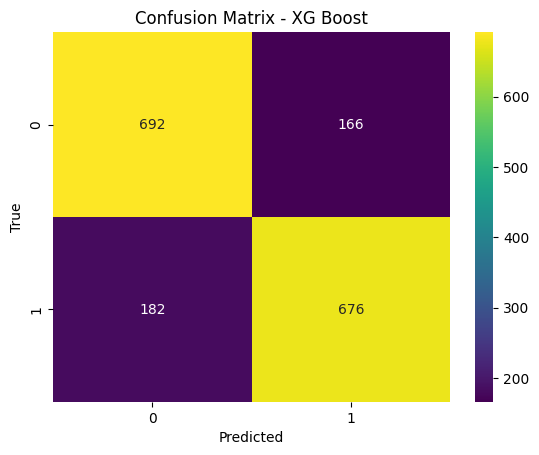

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_test_pred_labels)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis',
            xticklabels=best_xgb.classes_, yticklabels=best_xgb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XG Boost')
plt.show()